### Import relevant modules

In [2]:
import math
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Methodology: 
First, we calculate the unbiasing weights associated with each conformation sampled during the metadynamics simulation. For this purpose, we can use either of the following two approaches: 
1. Weights are calculated by considering the time-dependence of the bias potential
2. Weights are calculated using the bias potential obtained at the end of the simulation. This involves assuming a constant bias throughout the simulation. 
Below, we will use Method 2.

To calculate the weights, we need to use the PLUMED driver utility to read the HILLS file and the GROMACS trajectory file produced during the metadynamics simulation.

Install PLUMED from https://www.plumed.org/doc-v2.7/user-doc/html/masterclass-21-1.html. 

#### Some relevant constants

In [15]:
kbt=2.494339
minS=1.0
maxS=114.0
minS_actual=1.03
maxS_actual=112.9
nbin=25

### Evaluate bias on the full simulation using HILLS file and .xtc file by running PLUMED
#### This PLUMED run generates a COLVAR file with time-independent bias

In [ ]:
%%bash
plumed driver --plumed plumed.dat --mf_xtc abl1_md.xtc

#### Read the COLVAR file

In [5]:
data=pd.read_csv("COLVAR",sep="\s+", header=None, skiprows=1,usecols=[1,2,3]) 
data.columns=['s(R)','z(R)','bias']
data['s(R)']=data['s(R)'].round(2)

#### Calculate Maximum bias

In [6]:
bmax=data['bias'].max()

#### Calculate Boltzmann weights and write them to a file named "sR.weight"

In [7]:
data['weights']=np.exp((data['bias']-bmax)/kbt)
data.to_csv("sR.weight",index=False,sep="\t",columns=['s(R)','weights'])

#### Calculate bin width

In [8]:
bin_width = round((maxS-minS)/float(nbin-1),2)

# Block averaging

## Binning of data using cut: Create 25 equal-sized bins of s(R)

In [9]:
weightdf=pd.read_csv('sR.weight',sep="\t")
weightdf.columns=['s(R)','weights']
weightdf['bin_index'] = pd.cut(weightdf['s(R)'],bins=nbin,labels=[i for i in range(nbin)])

In [10]:
bin_list=list(weightdf['bin_index'].unique())

### Block sizes from 10 to 500 with steps of 10

In [59]:
block_size = np.array([i for i in range(10,510,10)])
nblocks = np.array(len(data)/block_size).astype(int)

#### We perform block averaging by dividing data in "weighdf" containing bias weights into several blocks. We can try different block sizes ranging from 10 to 500 in steps of 10. We need a separate block averaging calculation for each block size. For each block size, do the following steps:

#### Algorithm: Take 1 block at a time $\rightarrow$ Sort into bins $\rightarrow$ do block average within each bin $\rightarrow$ store block averages and squared block averages in a series and update these values in a cumulative manner $\rightarrow$  Go to a new block and repeat

1. Create a "block" dataframe starting with "start" timeframe and taking upto "end" timeframe that differs from start by "block_size".
2. Using this "block" dataframe, create a "block_grp" groupby object to sort data by bins.
3. Compute block average within each bin and store the data into "block_ave" series object.
4. Store block averages within each bin in "xbar" series and squared block averages in each bin in "xbarsq" series in a cumulative manner as we loop over the blocks.
5. Store number of blocks (nblocks; 0), block_size (n; 1), block averages (xbar; 2), squared block averages (xbarsq; 3) as a tuple in "xbar_xbarsq" list.

In [63]:
xbar_xbarsq=[]
for i in range(len(block_size)):
    xbar=pd.Series(index=bin_list,dtype=float,data=0)
    xbarsq=pd.Series(index=bin_list,dtype=float,data=0)
    for nblock in range(0, nblocks[i]): # loop over each block
        n = block_size[i]
        start = nblock * n # start timeframe for block
        end = start + n   # End timeframe for block 
        weightcopy=weightdf.copy()
        block=weightcopy[start:end]
        block_grp=block.groupby('bin_index') 
        block_ave=block_grp['weights'].sum()/n
        for binn in range(len(bin_list)):
            xbar[binn]+=block_ave[binn]
            xbarsq[binn]+=block_ave[binn]*block_ave[binn]
    xbar_xbarsq.append((nblocks[i],block_size[i],xbar,xbarsq))

### Calculate average Gibbs free energies and estimate standard error

1. Now, we obtain average weight $\bar{w}$ within each bin by dividing block_ave by blocksize (n)
2. Free energy is given by $G = -k_bT.\ln\bar{w}$
3. Variance in bias is calculated as $$\sigma^2(\bar w)=\frac{\bar{w}^²-\bar{(w)}^2}{(n-1)}$$
4. Variance in free-energy is calculated as:

$$\sigma^2(G)=\sigma^2(-k_bT\ln\bar{w})$$
$$\sigma^2(G)=(k_bT)^2.\sigma^2(\ln\bar{w})$$

Using the delta method, in order to obtain a variance of a function of x (that is normally distributed) we can take derivative of function with respect to x and then divide var(x) by the square of derivative of the function

$$\sigma^2(\ln\bar w)=\frac{1}{\bar{w}^²}.\sigma^2(\bar{w})$$


$$\sigma^2(G)=\left(\frac{k_bT}{\bar w}\right)^2.\sigma^2(w)$$

5. Standard error is estimated as $$error(G) =\sqrt\frac{\sigma^2(G)}{n}$$


$$error(G) =\frac{k_bT}{\bar w}\sqrt\frac{\sigma^2(\bar w)}{n}$$

6. For each block size (n), we save a separate fes{n}-np.dat file that contains values of s(R), norm. s(R), average free-energies within each bin, and the associated error (in kcal/mol)

In [70]:
sR_series = pd.Series(dtype=float,data=[(minS + (float(i) * bin_width)) for i in range(len(bin_list))])
for i in range(len(block_size)):
    numblock=xbar_xbarsq[i][0]
    n=xbar_xbarsq[i][1]
    result=pd.DataFrame()
    result['s(R)']=sR_series
    result['norm s(R)']=(result['s(R)']-minS)/(maxS-minS)
    result['Weight']=xbar_xbarsq[i][2]/n # point 1: average weight (wbar) calculation
    result['Free Energy']=-kbt * np.log(result['Weight']) # point 2: free-energy calculation
    result[r'$\sigma^2(w)$']= (xbar_xbarsq[i][3]-result['Weight']**2)/(n-1)  # point 3: bias variance calculation
    result['error']=(kbt/result['Weight'])*(np.sqrt(result[r'$\sigma^2(w)$']/n)) # point 5: error calculation
    outdf=result[['s(R)','norm s(R)','Free Energy','error']].copy()
    outdf['Free Energy']=(outdf['Free Energy']-outdf['Free Energy'].min())/4.184 # make min zero and unit conv.
    outdf['error']=outdf['error']/4.184
    outdf=outdf.round(2)
    outdf.to_csv(f'fes{n}-np.dat',sep="\t",index=False)

### Error estimation
Read errors in each bin and compute average error over all the bins and store in err.blocks

In [67]:
%%bash
echo > err.blocks
for i in {10..500..10}
do
 a=$(awk '{tot+=$4}END{print (tot/NR)}' fes"$i"-np.dat)
 echo $i $a >> err.blocks
done

### Plotting of mean error over all the bins vs. block size

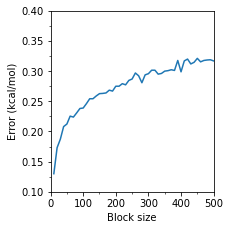

In [68]:
df=pd.read_csv("err.blocks",sep="\s+",header=None,skiprows=1)

fig,ax=plt.subplots(figsize=(3.3,3.3))


ax.plot(df[0],df[1])
ax.set_ylim([0.10,0.40])
ax.set_xlim([0,500])
ax.set_xlabel(r'Block size')
ax.set_ylabel('Error (kcal/mol)')

plt.rcParams['font.family'] = "sans-serif"

ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
plt.tight_layout()
plt.savefig("error-non-phos.pdf",dpi=600)